# MED3pa utilisation example

This tutorial guides you through the process of setting up and running comprehensive experiments using the `MED3pa` subpackage. It includes steps to execute MED3pa experiment with `Med3paExperiment`.

## Get Data and BaseModel.

In [1]:
import os
import pandas as pd
import wget
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from MED3pa.datasets import DatasetsManager
from MED3pa.med3pa import Med3paExperiment
from MED3pa.models import BaseModelManager
from MED3pa.visualization.mdr_visualization import visualize_mdr
from MED3pa.visualization.profiles_visualization import visualize_tree

In [2]:
def oym_process(df):
    # One hot encoding of categorical variables
    categorical_variables = ['living_status', 'admission_group', 'service_group']
    df = pd.get_dummies(df, columns=categorical_variables)
    df = pd.get_dummies(df, columns=['gender'], drop_first=True)

    # Convert boolean to int
    boolean_variables = ['CSO', 'oym']
    df[boolean_variables] = df[boolean_variables].astype(int)
    
    # Extract target and features
    x_features = df.drop(columns=['oym'])
    y = df['oym'].to_numpy()
    return x_features, y

In [3]:
# Get Data
os.makedirs("data/datasets/oym", exist_ok=True)
wget.download('https://zenodo.org/records/12954673/files/dataset.csv?download=1',
                      out=os.getcwd() + '\\data\\datasets\\oym\\dataset.csv')
df = pd.read_csv(os.getcwd() + '\\data\\datasets\\oym\\dataset.csv')

# Process Data
x, y = oym_process(df)
x_train, x_evaluation, y_train, y_evaluation = train_test_split(x, y, test_size=0.3, random_state=54288)

# Train the BaseModel
clf = RandomForestClassifier(max_depth=4, random_state=42).fit(x_train, y_train)

## Define MED3pa experiment characteristics

In [4]:
med3pa_params = {"uncertainty_metric":"sigmoidal_error",
    "ipc_type":'RandomForestRegressor',
    "ipc_params":{'n_estimators': 100},
    "apc_params":{'max_depth': 6},
    "ipc_grid_params":{'n_estimators': [50, 100, 200],
                     'max_depth': [2, 4, 6]},
    "apc_grid_params":{'min_samples_leaf': [2, 4, 6]},
    "samples_ratio_min":0,
    "samples_ratio_max":10,
    "samples_ratio_step":5,
    "evaluate_models":True}

## MED3pa evaluation of BaseModel

Running MED3pa Experiment on the test set:


C:\ProgramData\miniconda3\envs\med3pa\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


IPC Model training complete.
IPC Model optimization complete.
Individualized confidence scores calculated.
APC Model training complete.
APC Model optimization complete.
Aggregated confidence scores calculated.
Mixed confidence scores calculated.
Results extracted for minimum_samples_ratio =  0
Results extracted for minimum_samples_ratio =  5
Results extracted for minimum_samples_ratio =  10
Tab reference not found in
Dictionary successfully saved to results/oym/MED3paResults_20251017114225.MED3paResults


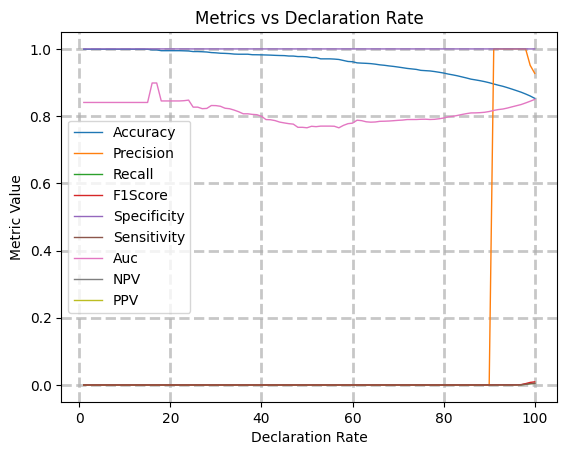

Tree visualization generated: 'results/oym/profiles.html'
Serving at http://localhost:8000


127.0.0.1 - - [17/Oct/2025 11:42:27] "GET /results/oym/profiles.html HTTP/1.1" 200 -
127.0.0.1 - - [17/Oct/2025 11:42:27] "GET /results/oym/tree_template/style.css HTTP/1.1" 200 -
127.0.0.1 - - [17/Oct/2025 11:42:27] "GET /results/oym/tree_template/script.js HTTP/1.1" 200 -




To open the HTML file in the web browser:
1. Activate your conda environment: conda start <env_name>;
2. Start a local Python server: python -m http.server 8000;
3. Open the following URL in your browser: http://localhost:8000/results/oym/profiles.html


In [5]:
# Initialize the DatasetsManager
datasets = DatasetsManager()
datasets.set_from_data(dataset_type="testing",
                       observations=x_evaluation.to_numpy(),
                       true_labels=y_evaluation,
                       column_labels=x_evaluation.columns)
# Initialize the BaseModelManager
base_model_manager = BaseModelManager(model=clf)

# Execute the MED3PA experiment
results = Med3paExperiment.run(
    datasets_manager=datasets,
    base_model_manager=base_model_manager,
    **med3pa_params
)

# Save the results to a specified directory
results.save(file_path='results/oym')

# Visualize results
visualize_mdr(result=results, filename='results/oym/mdr')
visualize_tree(result=results, filename='results/oym/profiles')